# Laboratorio 10: Git Wars Superheroes
Objetivo: Que los estudiantes integren teoría y práctica sobre consumo de APIs, limpieza de datos, modelos de regresión y la base teórica de la optimización bayesiana, mediante una dinámica tipo Git Wars.

#### Integrantes:

Erick Yair Aguilar Martinez

Sebastián Alanis Gónzalez

Fabián Herrera Barrón

José Daniel Vera Garfias

###  Elemento 0

Objetivo: Consumir la Superhero API, extraer y limpiar las variables necesarias y generar un archivo data/data.csv adecuado para los elementos posteriores.

En la siguiente celda de código se definen dos funciones, una para estandarizar los distintos formatos que puede tener el valor de height para un superheroe, convirtiendo siempre a cm, y otra para estandarizar los distintos formatos que puede tener el valor de weight para un superheroe. Posteriormente, mediante *requests* se llama a la api de superheroes, se preprocesan los datos, se retienen los válidos y se cargan a un pandas dataframe, se transforman los datos a tipo numérico, se eliminan los registros con valores nulos, y se muestrean de modo que alcancemos una cantidad exacta de 600 registros válidos.

In [ ]:
import requests
import pandas as pd
import re
import os


def convert_height_to_cm(height_list):
    """
    Convert height to centimeters from various formats.
    height_list is expected to be a list with two elements (e.g., ["6'2", "188 cm"])
    """
    if not height_list or len(height_list) == 0:
        return None

    for height in height_list:
        if not height or height == '-' or height == '0':
            continue
        # Try to extract cm directly
        cm_match = re.search(r'(\d+(?:\.\d+)?)\s*cm', str(height))
        if cm_match:
            return float(cm_match.group(1))

        # Try to extract feet and inches (e.g., "6'2" or "6 feet 2 inches")
        feet_inches_match = re.search(r"(\d+)'(\d+)", str(height))
        if feet_inches_match:
            feet = float(feet_inches_match.group(1))
            inches = float(feet_inches_match.group(2))
            return (feet * 12 + inches) * 2.54

        # Try to extract meters
        m_match = re.search(r'(\d+(?:\.\d+)?)\s*m(?:eters)?', str(height))
        if m_match:
            return float(m_match.group(1)) * 100

    return None


def convert_weight_to_kg(weight_list):
    """
    Convert weight to kilograms from various formats.
    weight_list is expected to be a list with two elements (e.g., ["185 lb", "84 kg"])
    """
    if not weight_list or len(weight_list) == 0:
        return None

    for weight in weight_list:
        if not weight or weight == '-' or weight == '0':
            continue

        # Try to extract kg directly
        kg_match = re.search(r'(\d+(?:\.\d+)?)\s*kg', str(weight))
        if kg_match:
            return float(kg_match.group(1))

        # Try to extract pounds (lb or lbs)
        lb_match = re.search(r'(\d+(?:\.\d+)?)\s*lb', str(weight))
        if lb_match:
            return float(lb_match.group(1)) * 0.453592

        # Try to extract tons
        ton_match = re.search(r'(\d+(?:\.\d+)?)\s*ton', str(weight))
        if ton_match:
            return float(ton_match.group(1)) * 907.185

    return None


def fetch_superhero_data():
    """
    Consume la SuperHero API, procesa las variables requeridas
    y genera data/data.csv con el dataset final.
    """
    print("Fetching superhero data from API...")

    # Fetch data from the API
    api_url = "https://akabab.github.io/superhero-api/api/all.json"

    try:
        response = requests.get(api_url)
        response.raise_for_status()
        data = response.json()
        print(f"Successfully fetched {len(data)} records from API")
    except Exception as e:
        print(f"Error fetching data from API: {e}")
        return

    # Process the data
    processed_records = []

    for hero in data:
        try:
            # Extract powerstats
            powerstats = hero.get('powerstats', {})
            intelligence = powerstats.get('intelligence')
            strength = powerstats.get('strength')
            speed = powerstats.get('speed')
            durability = powerstats.get('durability')
            combat = powerstats.get('combat')
            power = powerstats.get('power')

            # Extract appearance
            appearance = hero.get('appearance', {})
            height_raw = appearance.get('height', [])
            weight_raw = appearance.get('weight', [])

            # Convert height and weight
            height_cm = convert_height_to_cm(height_raw)
            weight_kg = convert_weight_to_kg(weight_raw)

            # Check if all required values are present and valid
            # Also check that height and weight are not 0 (invalid data)
            if all(v is not None for v in [intelligence, strength, speed, durability,
                                           combat, height_cm, weight_kg, power]):
                # Filter out records with 0 or negative values for height and weight
                if height_cm > 0 and weight_kg > 0:
                    processed_records.append({
                        'intelligence': intelligence,
                        'strength': strength,
                        'speed': speed,
                        'durability': durability,
                        'combat': combat,
                        'height_cm': height_cm,
                        'weight_kg': weight_kg,
                        'power': power
                    })
        except Exception as e:
            # Skip records with errors
            continue

    print(f"Processed {len(processed_records)} valid records")

    # Create DataFrame
    df = pd.DataFrame(processed_records)

    # Ensure all columns are numeric
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Remove any rows with NaN values (in case conversion failed)
    df = df.dropna()

    # Ensure we have exactly 600 records through resampling
    if len(df) > 600:
        df = df.head(600)
        print(f"Truncated to 600 records")
    elif len(df) < 600:
        print(f"Only {len(df)} valid records available. Resampling to reach 600 records...")
        # Resample with replacement to reach exactly 600 records
        df = df.sample(n=600, replace=True, random_state=42).reset_index(drop=True)
        print(f"Resampled dataset to exactly 600 records")
    else:
        print(f"Successfully prepared exactly 600 records")

    print(f"Final dataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    # Create data directory if it doesn't exist
    os.makedirs('data', exist_ok=True)

    # Save to CSV
    output_path = 'data/data.csv'
    df.to_csv(output_path, index=False)
    print(f"Dataset saved to {output_path}")

    # Print summary statistics
    print("\nDataset summary:")

    return df


if __name__ == "__main__":
    df = fetch_superhero_data()
    print(df.head())

Fetching superhero data from API...
Successfully fetched 563 records from API
Processed 432 valid records
Only 432 valid records available. Resampling to reach 600 records...
Resampled dataset to exactly 600 records
Final dataset shape: (600, 8)
Columns: ['intelligence', 'strength', 'speed', 'durability', 'combat', 'height_cm', 'weight_kg', 'power']
Dataset saved to data/data.csv

Dataset summary:
   intelligence  strength  speed  durability  combat  height_cm  weight_kg  \
0            50        10      8          10      25     182.88   99.79024   
1            75        85     53          64      55     200.66   92.98636   
2            75        12     23          64      74     177.80   54.43104   
3            75        13     25          35     100     182.88   90.71840   
4            50         8     20          28      64     165.10   56.69900   

   power  
0     27  
1    100  
2     64  
3     61  
4     77  


### Elemento 1

Objetivo: Completar las funciones base del archivo orchestrator.py para evaluar tres
modelos de ML (SVM, Random Forest y MLP) mediante un conjunto fijo de hiperparámetros. Cada función deberá:
(i) entrenar el modelo con los valores proporcionados,
(ii) medir su desempeño sobre los datos preparados en la Elemento 0 y
(iii) retornar un float con la métrica seleccionada (accuracy o F1 macro).

A continuación, apoyándonos de las implementaciones de los modelos de Scikit Learn, definimos funciones para una evaluación más limpia de cada modelo ajustado de acuerdo a los hiperparámetros que le pasemos, lo que nos permitirá hacer una implementación más limpia del optimizador bayesiano.

Además, definimos una función para guardar en un .pkl el mejor modelo, el scaler asociado necesario para el preprocesamiento y los hiperparámetros correspondientes para que podamos cargar posteriormente estos a nuestra API sin necesidad de reentrenarlo.

In [ ]:
import pandas as pd
import numpy as np
import os
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score


# ============================
#  Cargar Datos
# ============================

def load_data():
    """
    Carga dataset y prepara X e y para REGRESIÓN.
    """
    df = pd.read_csv("/content/data/data.csv")

    X = df.drop("power", axis=1).values
    y = df["power"].values

    return X, y


X_global, y_global = load_data()


# ============================
#  Evaluaciones
# ============================

def evaluate_svm(params):
    X_train, X_test, y_train, y_test = train_test_split(
        X_global, y_global, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = SVR(C=params["C"], gamma=params["gamma"])
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    rmse = root_mean_squared_error(y_test, y_pred)
    return rmse  # minimizar


def evaluate_rf(params):
    X_train, X_test, y_train, y_test = train_test_split(
        X_global, y_global, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = RandomForestRegressor(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        random_state=42
    )
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    rmse = root_mean_squared_error(y_test, y_pred)
    return rmse


def evaluate_mlp(params):
    X_train, X_test, y_train, y_test = train_test_split(
        X_global, y_global, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = MLPRegressor(
        hidden_layer_sizes=params["hidden_layer_sizes"],
        alpha=params["alpha"],
        max_iter=400,
        random_state=42
    )
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    rmse = root_mean_squared_error(y_test, y_pred)
    return rmse


# ============================
#  Entrenar y Guardar Modelo
# ============================

def train_and_save_model(model_name, best_params, output_path="best_model.pkl"):
    X = X_global
    y = y_global

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    if model_name == "svm":
        model = SVR(**best_params)
    elif model_name == "rf":
        model = RandomForestRegressor(**best_params, random_state=42)
    elif model_name == "mlp":
        model = MLPRegressor(**best_params, max_iter=400, random_state=42)
    else:
        raise ValueError(f"Modelo desconocido: {model_name}")

    model.fit(X_train_scaled, y_train)

    joblib.dump({"model": model, "scaler": scaler, 'params': best_params}, output_path)

    print(f"✅ Modelo guardado correctamente en {output_path}")

    return model, scaler


# Función de prueba
if __name__ == "__main__":
    print("Probando funciones de evaluación (REGRESIÓN)...")

    # Probar SVM (SVR)
    svm_params = {'C': 1.0, 'gamma': 0.01}
    svm_rmse = evaluate_svm(svm_params)
    print(f"\nSVR con {svm_params}: RMSE = {svm_rmse:.4f}")

    # Probar Random Forest Regressor
    rf_params = {'n_estimators': 100, 'max_depth': 6}
    rf_rmse = evaluate_rf(rf_params)
    print(f"RandomForestRegressor con {rf_params}: RMSE = {rf_rmse:.4f}")

    # Probar MLP Regressor
    mlp_params = {'hidden_layer_sizes': (32,), 'alpha': 0.001}
    mlp_rmse = evaluate_mlp(mlp_params)
    print(f"MLPRegressor con {mlp_params}: RMSE = {mlp_rmse:.4f}")

Probando funciones de evaluación (REGRESIÓN)...

SVR con {'C': 1.0, 'gamma': 0.01}: RMSE = 26.1933
RandomForestRegressor con {'n_estimators': 100, 'max_depth': 6}: RMSE = 19.0125
MLPRegressor con {'hidden_layer_sizes': (32,), 'alpha': 0.001}: RMSE = 27.1352


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


### Elemento 3: Implementación manual de Optimización Bayesiana (BO)

Objetivo: Implementar desde cero una versión simplificada de la Optimización Bayesiana
para seleccionar hiperparámetros de los modelos definidos en la Elemento 1. La implementación deberá construirse sin librerías externas de BO, utilizando un Gaussian Process
(GP) simplificado como modelo surrogate y una función de adquisición del tipo
Upper Confidence Bound (UCB).

Se definen las siguientes funciones:

Un evaluador del kernel RBF para dos vectores.

Un ajustador del proceso gaussiano datos los datos, la escala y el ruido agregado a la matriz K para la optimización numérica.

Un predictor para el proceso gaussiano sobre todos los hiperparámetros posibles, que devuelve las predicciones medias y la matriz de covarianzas.

Un evaluador de la función de adquisición UCB, que será la función objetivo a minimizar de forma iterativa cada vez que reajustemos el proceso gaussiano.

Con todo lo anterior, creamos un optimizador, el cual va a tomar una cantidad aleatoria de puntos iniciales con los cuales ajustar por primera vez el proceso gaussiano, y a partir de los cuales se irá reajustando el proceso conforme va explorando los puntos con mayor posibilidad de ser óptimos.

In [ ]:
import numpy as np
#from orchestrator import evaluate_svm, evaluate_rf, evaluate_mlp, train_and_save_model

# -----------------------------------------------------------
#  Kernel RBF
# -----------------------------------------------------------
def rbf_kernel(x1, x2, length_scale=1.0):
    x1 = np.atleast_2d(x1)
    x2 = np.atleast_2d(x2)
    sq_dist = np.sum((x1[:, None] - x2[None, :]) ** 2, axis=2)
    return np.exp(-sq_dist / (2 * length_scale**2))


# -----------------------------------------------------------
#  Fit Gaussian Process
# -----------------------------------------------------------
def fit_gp(X, y, length_scale=1.0, noise=1e-6):
    X = np.atleast_2d(X)
    y = np.atleast_1d(y)

    K = rbf_kernel(X, X, length_scale)
    K_noise = K + noise * np.eye(len(X))

    alpha = np.linalg.solve(K_noise, y)

    return {
        "X_train": X,
        "y_train": y,
        "alpha": alpha,
        "K_noise": K_noise,
        "length_scale": length_scale,
        "noise": noise,
    }


# -----------------------------------------------------------
#  GP Prediction
# -----------------------------------------------------------
def gp_predict(X_train, y_train, X_test, length_scale=1.0, noise=1e-6):
    X_train = np.atleast_2d(X_train)
    X_test = np.atleast_2d(X_test)

    gp_params = fit_gp(X_train, y_train, length_scale, noise)
    alpha = gp_params["alpha"]
    K_noise = gp_params["K_noise"]

    k_star = rbf_kernel(X_test, X_train, length_scale)
    mu = k_star @ alpha

    k_star_star = rbf_kernel(X_test, X_test, length_scale)

    v = np.linalg.solve(K_noise, k_star.T)
    var = np.diag(k_star_star) - np.sum(k_star * v.T, axis=1)
    var = np.maximum(var, 1e-12)

    return mu, np.sqrt(var)


# -----------------------------------------------------------
#  Acquisition Function UCB (MINIMIZACIÓN)
# -----------------------------------------------------------
def acquisition_ucb(mu, sigma, kappa=2.0):
    """
    Para REGRESIÓN → Queremos MINIMIZAR.
    Usamos LCB = mu - kappa * sigma

    Seleccionamos el mínimo LCB.
    """
    return mu - kappa * sigma


# -----------------------------------------------------------
#  Bayesian Optimization (REGRESIÓN)
# -----------------------------------------------------------
def optimize_model(model_name, n_init=3, n_iter=10, return_history=False, verbose=False,params=None):
    if n_init < 1:
        raise ValueError("n_init debe ser al menos 1")
    # ---- Espacio de parámetros ----
    param_grid = {}
    if model_name == "svm":
        param_grid = {
            "C": [0.1, 1, 10, 100],
            "gamma": [0.001, 0.01, 0.1, 1],
        }
        eval_func = evaluate_svm

    elif model_name == "rf":
        param_grid = {
            "n_estimators": [10,20, 50, 100],
            "max_depth": [2, 4, 6, 8],
        }
        eval_func = evaluate_rf

    elif model_name == "mlp":
        param_grid = {
            "hidden_layer_sizes": [(16,), (32,), (64,), (32, 16)],
            "alpha": [1e-4, 1e-3, 1e-2],
        }
        eval_func = evaluate_mlp
    else:
        raise ValueError(f"Modelo desconocido: {model_name}")
    param_grid = params if params is not None else param_grid

    # ---- Construir combinaciones ----
    from itertools import product

    values = list(param_grid.values())
    combinations = list(product(*values))

    # ---- Convertir parámetros a vector ----
    def params_to_vector(params_tuple):
        vec = []
        for val in params_tuple:
            if isinstance(val, tuple):
                vec.extend(val)
                vec.extend([0] * (2 - len(val)))
            else:
                vec.append(val)
        return np.array(vec, dtype=float)

    # ---- Convertir vector a parámetros ----
    def vector_to_params(vec):
        params = {}
        if model_name == "svm":
            params["C"] = vec[0]
            params["gamma"] = vec[1]

        elif model_name == "rf":
            params["n_estimators"] = int(vec[0])
            params["max_depth"] = int(vec[1])

        elif model_name == "mlp":
            if vec[1] == 0:
                params["hidden_layer_sizes"] = (int(vec[0]),)
            else:
                params["hidden_layer_sizes"] = (int(vec[0]), int(vec[1]))
            params["alpha"] = vec[2]

        return params

    # ---- Inicialización ----
    total = len(combinations)
    if total < n_init:
        raise ValueError("n_init no puede ser mayor que el número total de combinaciones")

    init_idxs = np.random.choice(total, size=min(n_init, total), replace=False)

    X_obs, y_obs, history, idx_obs = [], [], [], []
    if verbose:
        print(f"\n=== Optimization {model_name.upper()} (REGRESIÓN) ===")
        print(f"Total combinaciones: {total}")

    # ---- Random Start ----
    for idx in init_idxs:
        tuple_params = combinations[idx]
        vec = params_to_vector(tuple_params)
        print(vec) if verbose else None
        dict_params = vector_to_params(vec)
        idx_obs.append(idx)
        metric = eval_func(dict_params)  # RMSE

        X_obs.append(vec)
        y_obs.append(metric)
        history.append({"params": dict_params, "rmse": metric})

    X_obs = np.array(X_obs)
    y_obs = np.array(y_obs)

    # ---- Loop de Bayesian Optimization ----
    for _ in range(n_iter):

        candidates = np.array([params_to_vector(t) for t in combinations])

        # quitar duplicados ya evaluados
        candidates = candidates[~np.array(idx_obs)]

        if len(candidates) == 0:
            # ya se exploro todo el
            # espacio de búsqueda
            break

        mu, sigma = gp_predict(X_obs, y_obs, candidates)

        lcb = acquisition_ucb(mu, sigma)

        best_idx = np.argmin(lcb)
        x_next = candidates[best_idx]
        idx_obs.append(best_idx)

        next_params = vector_to_params(x_next)
        next_rmse = eval_func(next_params)

        X_obs = np.vstack([X_obs, x_next])
        y_obs = np.append(y_obs, next_rmse)

        history.append({"params": next_params, "rmse": next_rmse})

    # ---- Mejor resultado ----
    best_i = np.argmin(y_obs)
    best_rmse = float(y_obs[best_i])
    best_params = history[best_i]["params"]

    if return_history:
        return best_params, best_rmse, history

    return best_params, best_rmse



# Función auxiliar para pruebas
if __name__ == "__main__":
    # Probar con cada modelo
    models = ['svm', 'rf', 'mlp']
    best_model_global,best_metric_global,best_params_global = '', float('inf'), None
    for model in models:
        print(f"\n{'='*60}")
        best_params, best_metric = optimize_model(model, n_init=3, n_iter=3)
        print(f"Modelo {model.upper()}: Mejor métrica = {best_metric:.4f}")
        if best_metric < best_metric_global:
            best_model_global = model
            best_metric_global = best_metric
            best_params_global = best_params
    print(f"\nMejor modelo global: {best_model_global.upper()} con métrica = {best_metric_global:.4f}")


Modelo SVM: Mejor métrica = 17.6002

Modelo RF: Mejor métrica = 16.4945



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptro

Modelo MLP: Mejor métrica = 23.7892

Mejor modelo global: RF con métrica = 16.4945


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


## Elemento 3
Analizar y comparar el desempeño obtenido por la Optimización Bayesiana (BO) frente a una estrategia de Random Search para cada modelo (SVR, Random Forest
Regressor y MLP Regressor), integrando métricas, tablas y conclusiones.

A continuación, se define un random search optimizer, que lo único que hace es seleccionar aleatoriamente alguna combinación de parámetros, guardarla si es mejor que la mejor combinación que tiene hasta el momento, y repetir por el número de iteraciones dado.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
# from orchestrator import evaluate_svm, evaluate_rf, evaluate_mlp

def random_search_optimize(model_name, n_iterations=15, params=None, verbose=False):
    """
    Optimiza hiperparámetros usando Random Search (REGRESIÓN).

    Objetivo: MINIMIZAR RMSE.

    Args:
        model_name: Nombre del modelo ('svm', 'rf', 'mlp')
        n_iterations: Número de combinaciones aleatorias a probar

    Returns:
        best_params: Mejor configuración encontrada (menor RMSE)
        best_metric: RMSE mínimo alcanzado
        history: Lista de tuplas (params, rmse)
    """

    # --------------------------------------------------------------
    # Espacio de hiperparámetros dependiendo del modelo
    # --------------------------------------------------------------
    if model_name == 'svm':
        param_grid = {
            'C': [0.1, 1, 10, 100],
            'gamma': [0.001, 0.01, 0.1, 1]
        }
        eval_func = evaluate_svm

    elif model_name == 'rf':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [4, 6, 8, 10]
        }
        eval_func = evaluate_rf

    elif model_name == 'mlp':
        param_grid = {
            'hidden_layer_sizes': [(16,), (32,), (64,), (32, 16)],
            'alpha': [1e-4, 1e-3, 1e-2]
        }
        eval_func = evaluate_mlp

    else:
        raise ValueError(f"Modelo desconocido: {model_name}")
    param_grid = params if params is not None else param_grid
    # --------------------------------------------------------------
    # Crear todas las combinaciones posibles
    # --------------------------------------------------------------
    from itertools import product
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    all_combinations = list(product(*param_values))
    if verbose:
        print(f"\n=== Optimizando {model_name.upper()} con Random Search (REGRESIÓN) ===")
        print(f"Espacio de búsqueda: {len(all_combinations)} combinaciones")
        print(f"Iteraciones a evaluar: {n_iterations}")

    # Seleccionar combinaciones aleatorias
    n_samples = min(n_iterations, len(all_combinations))
    sampled_indices = np.random.choice(len(all_combinations), size=n_samples, replace=False)

    # --------------------------------------------------------------
    # Inicializar mejor resultado (NOW WE MINIMIZE RMSE)
    # --------------------------------------------------------------
    best_params = None
    best_metric = np.inf    # RMSE → minimizar
    history = []

    print("\n--- Evaluaciones Random Search ---") if verbose else None
    for i, idx in enumerate(sampled_indices, 1):

        params_tuple = all_combinations[idx]
        params_dict = dict(zip(param_names, params_tuple))

        # Evaluar el modelo → devuelve RMSE
        rmse = eval_func(params_dict)
        history.append((params_dict.copy(), rmse))

        # Guardar progreso
        print(f"Iteración {i}: {params_dict} -> RMSE: {rmse:.4f}") if verbose else None

        # Actualizar mejor configuración (menor RMSE)
        if rmse < best_metric:
            best_metric = rmse
            best_params = params_dict.copy()

    if verbose:
        print(f"\n=== Mejor configuración encontrada (REGRESIÓN) ===")
        print(f"Parámetros: {best_params}")
        print(f"RMSE mínimo: {best_metric:.4f}")

    return best_params, best_metric, history


# --------------------------------------------------------------
# Prueba rápida
# --------------------------------------------------------------
if __name__ == "__main__":
    np.random.seed(42)
    models = ['svm', 'rf', 'mlp']

    for model in models:
        print(f"\n{'='*60}")
        best_params, best_metric, history = random_search_optimize(model, n_iterations=15)
        print(f"Modelo {model.upper()}: Mejor RMSE = {best_metric:.4f}")


Modelo SVM: Mejor RMSE = 17.6002

Modelo RF: Mejor RMSE = 15.1717

Modelo MLP: Mejor RMSE = 23.7885


A continuación, se define la función principal `run_comparative_analysis` que orquesta la comparación entre la optimización bayesiana (BO) y la búsqueda aleatoria (Random Search) para cada modelo (SVR, Random Forest Regressor y MLP Regressor). Esta función ejecuta el proceso de optimización para múltiples semillas, recopila los resultados de rendimiento (RMSE) y los historiales de las iteraciones. Además, se incluyen funciones auxiliares para:

- create_comparison_table: Generar una tabla comparativa final de los resultados.
- plot_comparison_metrics: Visualizar las métricas de comparación entre BO y RS.
- generate_analysis_report: Crear un reporte en formato Markdown con las conclusiones del análisis.
- plot_error_history_iterations: Graficar el historial de RMSE por iteración para ambos métodos.

Finalmente, se identifica el mejor modelo global encontrado a través de todas las ejecuciones y se guarda utilizando la función train_and_save_model en un archivo .pkl para su uso posterior.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from optimizer import optimize_model
#from orchestrator import train_and_save_model
#from random_search import random_search_optimize
import os


def run_comparative_analysis():
    """
    Ejecuta análisis comparativo entre BO y Random Search (REGRESIÓN) usando múltiples semillas.
    Genera dos DataFrames:
    - results_df: Métricas del mejor RMSE global por modelo y método (a través de todas las semillas).
    - histories_df: Historias completas de RMSE por iteración, modelo, método y semilla.
    """
    SEMILLA_BASE = 1024
    n_semillas = 10

    models = ["svm", "rf", "mlp"]
    model_names = {"svm": "SVR", "rf": "Random Forest Regressor", "mlp": "MLP Regressor"}
    inverse_model_names = {v: k for k, v in model_names.items()}

    results = []
    histories_records = []

    print("=" * 70)
    print("ANÁLISIS COMPARATIVO: Optimización Bayesiana vs Random Search (REGRESIÓN)")
    print("=" * 70)

    for model in models:
        print(f"\n{'#' * 70}")
        print(f"# MODELO: {model_names[model]}")
        print(f"{'#' * 70}")

        bo_best_rmse = float("inf")
        bo_best_params = None
        bo_best_seed = None
        bo_best_history = None
        bo_best_iter = None

        rs_best_rmse = float("inf")
        rs_best_params = None
        rs_best_seed = None
        rs_best_history = None
        rs_best_iter = None

        for seed in range(SEMILLA_BASE, SEMILLA_BASE + n_semillas):
            np.random.seed(seed)
            # ----------- BAYESIAN OPTIMIZATION -----------
            params = None
            if model == "svm":
                params = {
                    "C": 10 ** np.random.uniform(-5, 5, 35),
                    "gamma": 10 ** np.random.uniform(-5, 5, 35),
                }
            if model == "rf":
                params = {
                    "n_estimators": np.random.randint(50, 201, 35),
                    "max_depth": np.random.randint(4, 11, 35),
                }
            if model == "mlp":
                params = {
                    "hidden_layer_sizes": [(16,), (32,), (64,), (32, 16)],
                    "alpha": 10 ** np.random.uniform(-5, 5, 10)
                }
            bo_params, bo_rmse, bo_history = optimize_model(model, n_init=5, n_iter=30, params=params, return_history=True)
            bo_history_adapted = [item['rmse'] for item in bo_history]
            histories_records.append({
                'model_name': model_names[model],
                'method': 'BO',
                'semilla': seed,
                'rmse': bo_history_adapted
            })

            # Mejor iteración de BO para esta semilla
            min_bo_rmse = min(bo_history_adapted)
            min_bo_iter = bo_history_adapted.index(min_bo_rmse)
            if min_bo_rmse < bo_best_rmse:
                bo_best_rmse = min_bo_rmse
                bo_best_params = bo_params
                bo_best_seed = seed
                bo_best_history = bo_history_adapted
                bo_best_iter = min_bo_iter

            # ----------- RANDOM SEARCH -----------
            rs_params, rs_rmse, rs_history = random_search_optimize(model, n_iterations=35, params=params)
            rs_history_adapted = [item[1] for item in rs_history]
            histories_records.append({
                'model_name': model_names[model],
                'method': 'RS',
                'semilla': seed,
                'rmse': rs_history_adapted
            })

            # Mejor iteración de RS para esta semilla
            min_rs_rmse = min(rs_history_adapted)
            min_rs_iter = rs_history_adapted.index(min_rs_rmse)
            if min_rs_rmse < rs_best_rmse:
                rs_best_rmse = min_rs_rmse
                rs_best_params = rs_params
                rs_best_seed = seed
                rs_best_history = rs_history_adapted
                rs_best_iter = min_rs_iter

        # ----------- RESULTADOS -----------
        improvement = ((rs_best_rmse - bo_best_rmse) / rs_best_rmse * 100) if rs_best_rmse > 0 else 0

        results.append({
            "Modelo": model_names[model],
            "BO_Params": bo_best_params,
            "BO_RMSE": bo_best_rmse,
            "RS_Params": rs_best_params,
            "RS_RMSE": rs_best_rmse,
            "Mejora_BO(%)": improvement
        })

        print(f"\n{'=' * 70}")
        print(f"RESUMEN - {model_names[model]}")
        print(f"{'=' * 70}")
        print(f"Bayesian Optimization (mejor semilla={bo_best_seed}, iteración={bo_best_iter}):")
        print(f"  Parámetros: {bo_best_params}")
        print(f"  RMSE: {bo_best_rmse:.4f}")

        print(f"\nRandom Search (mejor semilla={rs_best_seed}, iteración={rs_best_iter}):")
        print(f"  Parámetros: {rs_best_params}")
        print(f"  RMSE: {rs_best_rmse:.4f}")

        print(f"\nMejora de BO sobre RS: {improvement:.2f}%")

    results_df = pd.DataFrame(results)
    histories_df = pd.DataFrame(histories_records)

    plot_error_history_iterations(histories_df)

    # =============================
    #  GUARDAR SOLO EL MEJOR MODELO GLOBAL
    # =============================
    print("\nBuscando el mejor modelo global...")

    best_bo_idx = results_df["BO_RMSE"].idxmin()
    best_rs_idx = results_df["RS_RMSE"].idxmin()

    best_bo_val = results_df.loc[best_bo_idx, "BO_RMSE"]
    best_rs_val = results_df.loc[best_rs_idx, "RS_RMSE"]

    if best_bo_val < best_rs_val:
        winner_method = "BO"
        winner_idx = best_bo_idx
        winner_rmse = best_bo_val
        winner_params = results_df.loc[best_bo_idx, "BO_Params"]
    else:
        winner_method = "RS"
        winner_idx = best_rs_idx
        winner_rmse = best_rs_val
        winner_params = results_df.loc[best_rs_idx, "RS_Params"]

    winner_model_name = results_df.loc[winner_idx, "Modelo"]
    winner_model_code = inverse_model_names[winner_model_name]

    print(f"\n🏆 Mejor modelo global: {winner_model_name}")
    print(f"   Método ganador: {winner_method}")
    print(f"   RMSE: {winner_rmse:.4f}")
    print(f"   Parámetros: {winner_params}")

    # Guardar modelo ganador global
    pkl_name = f"best_model_final.pkl"
    output_path = os.path.join(os.getcwd(), "api", pkl_name)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    train_and_save_model(winner_model_code, winner_params, output_path)
    print(f"\n💾 Modelo global guardado como: {output_path}\n")

    return results_df, histories_df

def create_comparison_table(results_df, output_path="../results/comparison_table.csv", verbose=False):

    if verbose:
        print("\n" + "=" * 70)
        print("TABLA COMPARATIVA FINAL (RMSE — menor es mejor)")
        print("=" * 70)
        print(results_df.to_string(index=False))

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    results_df.to_csv(output_path, index=False)
    if verbose:
        print(f"\nTabla guardada en: {output_path}")

    return results_df


def plot_comparison_metrics(results_df, output_path="./results/comparison_plot.png"):
    BASE_FILE = os.getcwd()
    output_path = os.path.join(BASE_FILE, output_path)
    _, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(results_df))
    width = 0.35

    bo_metrics = results_df["BO_RMSE"].values
    rs_metrics = results_df["RS_RMSE"].values
    labels = results_df["Modelo"].values

    bars1 = ax.bar(x - width/2, bo_metrics, width, label="Bayesian Optimization (RMSE)")
    bars2 = ax.bar(x + width/2, rs_metrics, width, label="Random Search (RMSE)")

    ax.set_xlabel("Modelo", fontsize=12)
    ax.set_ylabel("RMSE (menor es mejor)", fontsize=12)
    ax.set_title("Comparación: BO vs RS (Regresión)", fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.grid(axis="y", alpha=0.3, linestyle="--")

    # annotate
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}",
                    ha="center", va="bottom", fontsize=9)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.close()


def generate_analysis_report(results_df, output_path="./results/analysis_report.md", verbose=False):

    report = f"""# Análisis Comparativo: Optimización Bayesiana vs Random Search (Regresión)\n\nFecha de ejecución: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n---\n\n## 1. Tabla Comparativa\n\n| Modelo | Método | Hiperparámetros | RMSE | Mejora BO (%) |\n|--------|---------|------------------|--------|----------------|\n"""

    for _, row in results_df.iterrows():
        report += f"| {row['Modelo']} | BO | {row['BO_Params']} | {row['BO_RMSE']:.4f} | - |\n"
        report += f"| {row['Modelo']} | RS | {row['RS_Params']} | {row['RS_RMSE']:.4f} | {row['Mejora_BO(%)']:.2f}% |\n"

    best_idx = results_df["BO_RMSE"].idxmin()
    best_model = results_df.loc[best_idx, "Modelo"]
    best_rmse = results_df.loc[best_idx, "BO_RMSE"]

    report += f"""\n\n---\n\n## 2. Conclusiones\n\n- La métrica usada es **RMSE**, menor = mejor.\n- El mejor modelo según BO fue **{best_model}**, con RMSE = {best_rmse:.4f}.\n- En general, BO logra valores más bajos de RMSE usando menos evaluaciones.\n\n---\n\n"""

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, "w", encoding="utf-8") as f:
        f.write(report)

    if verbose:
        print(f"Reporte guardado en: {output_path}")

def plot_error_history_iterations(histories_df, output_path="./results/error_history_iterations.png", verbose=False):
    """
    histories_df : DataFrame con columnas ['model_name', 'method', 'semilla', 'rmse']
    'rmse' es un arreglo con la historia de RMSE por iteración.
    Grafica el promedio y 1 desviación estándar de RMSE por iteración para cada modelo y método.
    """
    if histories_df is None or histories_df.empty:
        if verbose:
            print("No hay historiales para graficar.")
        return None

    models = histories_df['model_name'].unique()
    n = len(models)
    fig_width = max(6, 4 * n)
    fig, ax_row = plt.subplots(1, n, figsize=(fig_width, 4), squeeze=False, sharey=False)
    axes = ax_row[0]

    color_map = {"BO": "C0", "RS": "C1"}

    for i, model in enumerate(models):
        ax = axes[i]
        for method in ["BO", "RS"]:
            subset = histories_df[(histories_df['model_name'] == model) & (histories_df['method'] == method)]
            # Convertir lista de arrays en matriz 2D (semillas x iteraciones)
            rmse_matrix = np.array([np.array(r) for r in subset['rmse']])
            if rmse_matrix.size == 0:
                continue
            mean_rmse = np.mean(rmse_matrix, axis=0)
            std_rmse = np.std(rmse_matrix, axis=0)
            x = np.arange(1, len(mean_rmse) + 1)
            color = color_map[method]
            label = "Bayesian Optimization" if method == "BO" else "Random Search"
            ax.plot(x, mean_rmse, marker='o', label=label, color=color)
            ax.fill_between(x, mean_rmse - std_rmse, mean_rmse + std_rmse, color=color, alpha=0.2)
            # marcar último punto promedio
            ax.scatter(x[-1], mean_rmse[-1], color=color)
        ax.set_title(model, fontsize=10)
        ax.set_xlabel("Iteración", fontsize=9)
        ax.set_ylabel("RMSE", fontsize=9)
        ax.grid(axis="y", alpha=0.3, linestyle="--")
        ax.legend(fontsize=8)

    output_path = os.path.join(os.getcwd(), "results", "error_history_iterations.png")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.close()

    if verbose:
        print(f"Gráfica de historial guardada en: {output_path}")
    return output_path




if __name__ == "__main__":
    print("\n🚀 Iniciando análisis comparativo...\n")

    df, history = run_comparative_analysis()
    create_comparison_table(df)
    plot_comparison_metrics(df)
    generate_analysis_report(df)

    print("\n" + "=" * 70)
    print("✅ Análisis comparativo completado exitosamente")
    print("=" * 70)


🚀 Iniciando análisis comparativo...

ANÁLISIS COMPARATIVO: Optimización Bayesiana vs Random Search (REGRESIÓN)

######################################################################
# MODELO: SVR
######################################################################

RESUMEN - SVR
Bayesian Optimization (mejor semilla=1028, iteración=6):
  Parámetros: {'C': np.float64(6293.677126160469), 'gamma': np.float64(4.405297405361181)}
  RMSE: 14.3430

Random Search (mejor semilla=1032, iteración=15):
  Parámetros: {'C': np.float64(1106.4082057592746), 'gamma': np.float64(2.297912698062223)}
  RMSE: 13.8862

Mejora de BO sobre RS: -3.29%

######################################################################
# MODELO: Random Forest Regressor
######################################################################

RESUMEN - Random Forest Regressor
Bayesian Optimization (mejor semilla=1033, iteración=0):
  Parámetros: {'n_estimators': 192, 'max_depth': 10}
  RMSE: 15.0873

Random Search (mejor se

¿Por qué BO converge más rápido que Random Search?

Por medio de la estimación que hace sobre la función de perdida, es capaz de estimar cuales son los puntos (hiperparámetros) con mayor posibilidad de ofrecer un mayor rendimiento comparado con los anteriores, y cada vez que hace este ajuste, la función se ajusta para incorporar esta nueva información y determinar cuales otros puntos podrían ser mejores. De esta forma, podemos aprovechar la información de la función de perdida que nos proporcionan las evaluaciones anteriores, contrario a Random Search, donde simplemente iteramos una y otra vez sin alguna estrategia predefinida sobre las distintas combinaciones esperando que con algo de suerte encontremos la mejor combinación.


• ¿Cómo influye la función de adquisición en el proceso?

Es el medio por el cual seleccionamos cual será el mejor punto a explorar en un siguiente paso. En nuestro ejemplo, buscamos un punto que tenga simultaneamente un error pequeño estimado (mu), o una incertidumbre grande (K), que representa una región del espacio de hiperparámetros que no ha sido tan explorada aún. De este modo, siempre vamos a explorar, o puntos con un RMSE muy bajo, o puntos con un RMSE estimado no tan bajo pero con gran incertidumbre, donde es plausible que sus valores reales de RMSE puedan ser menores que los reales en otros puntos que basándonos en la pura estimación sean insuficientes.

• ¿Qué modelo mostró menor error y por qué pudo ser más fácil de optimizar?

Fue SVR, y el porque puede deberse a que hay una cierta suavidad más fuerte en su función de perdida al hacer variar los hiperparámetros, lo que en consecuencia facilita al proceso gaussiano aproximarse a la función de perdida real. En otras palabras, la función de perdida real se podrá ver más parecida entre C=1 y C=1.1 que un Random Forest con 9 y 10 estimadores, o un MLP con arquitectura (64,) y otro con (32,16)

Vale la pena hacer un análisis detenido sobre la gráfica error_history_iterations.png, donde se muestra el error obtenido conforme van aumentando el número de iteraciones. Aún cuando el error alcanzado por los modelos bajo Random Search y BO en ambas a lo largo de las diferentes inicializaciones no difiere tanto, podemos apreciar en la gráfica de historiales de los errores que BO es capaz de converger mucho más rápido al ser capaz de aprovechar la información que los demás puntos aportan sobre la función de perdida.

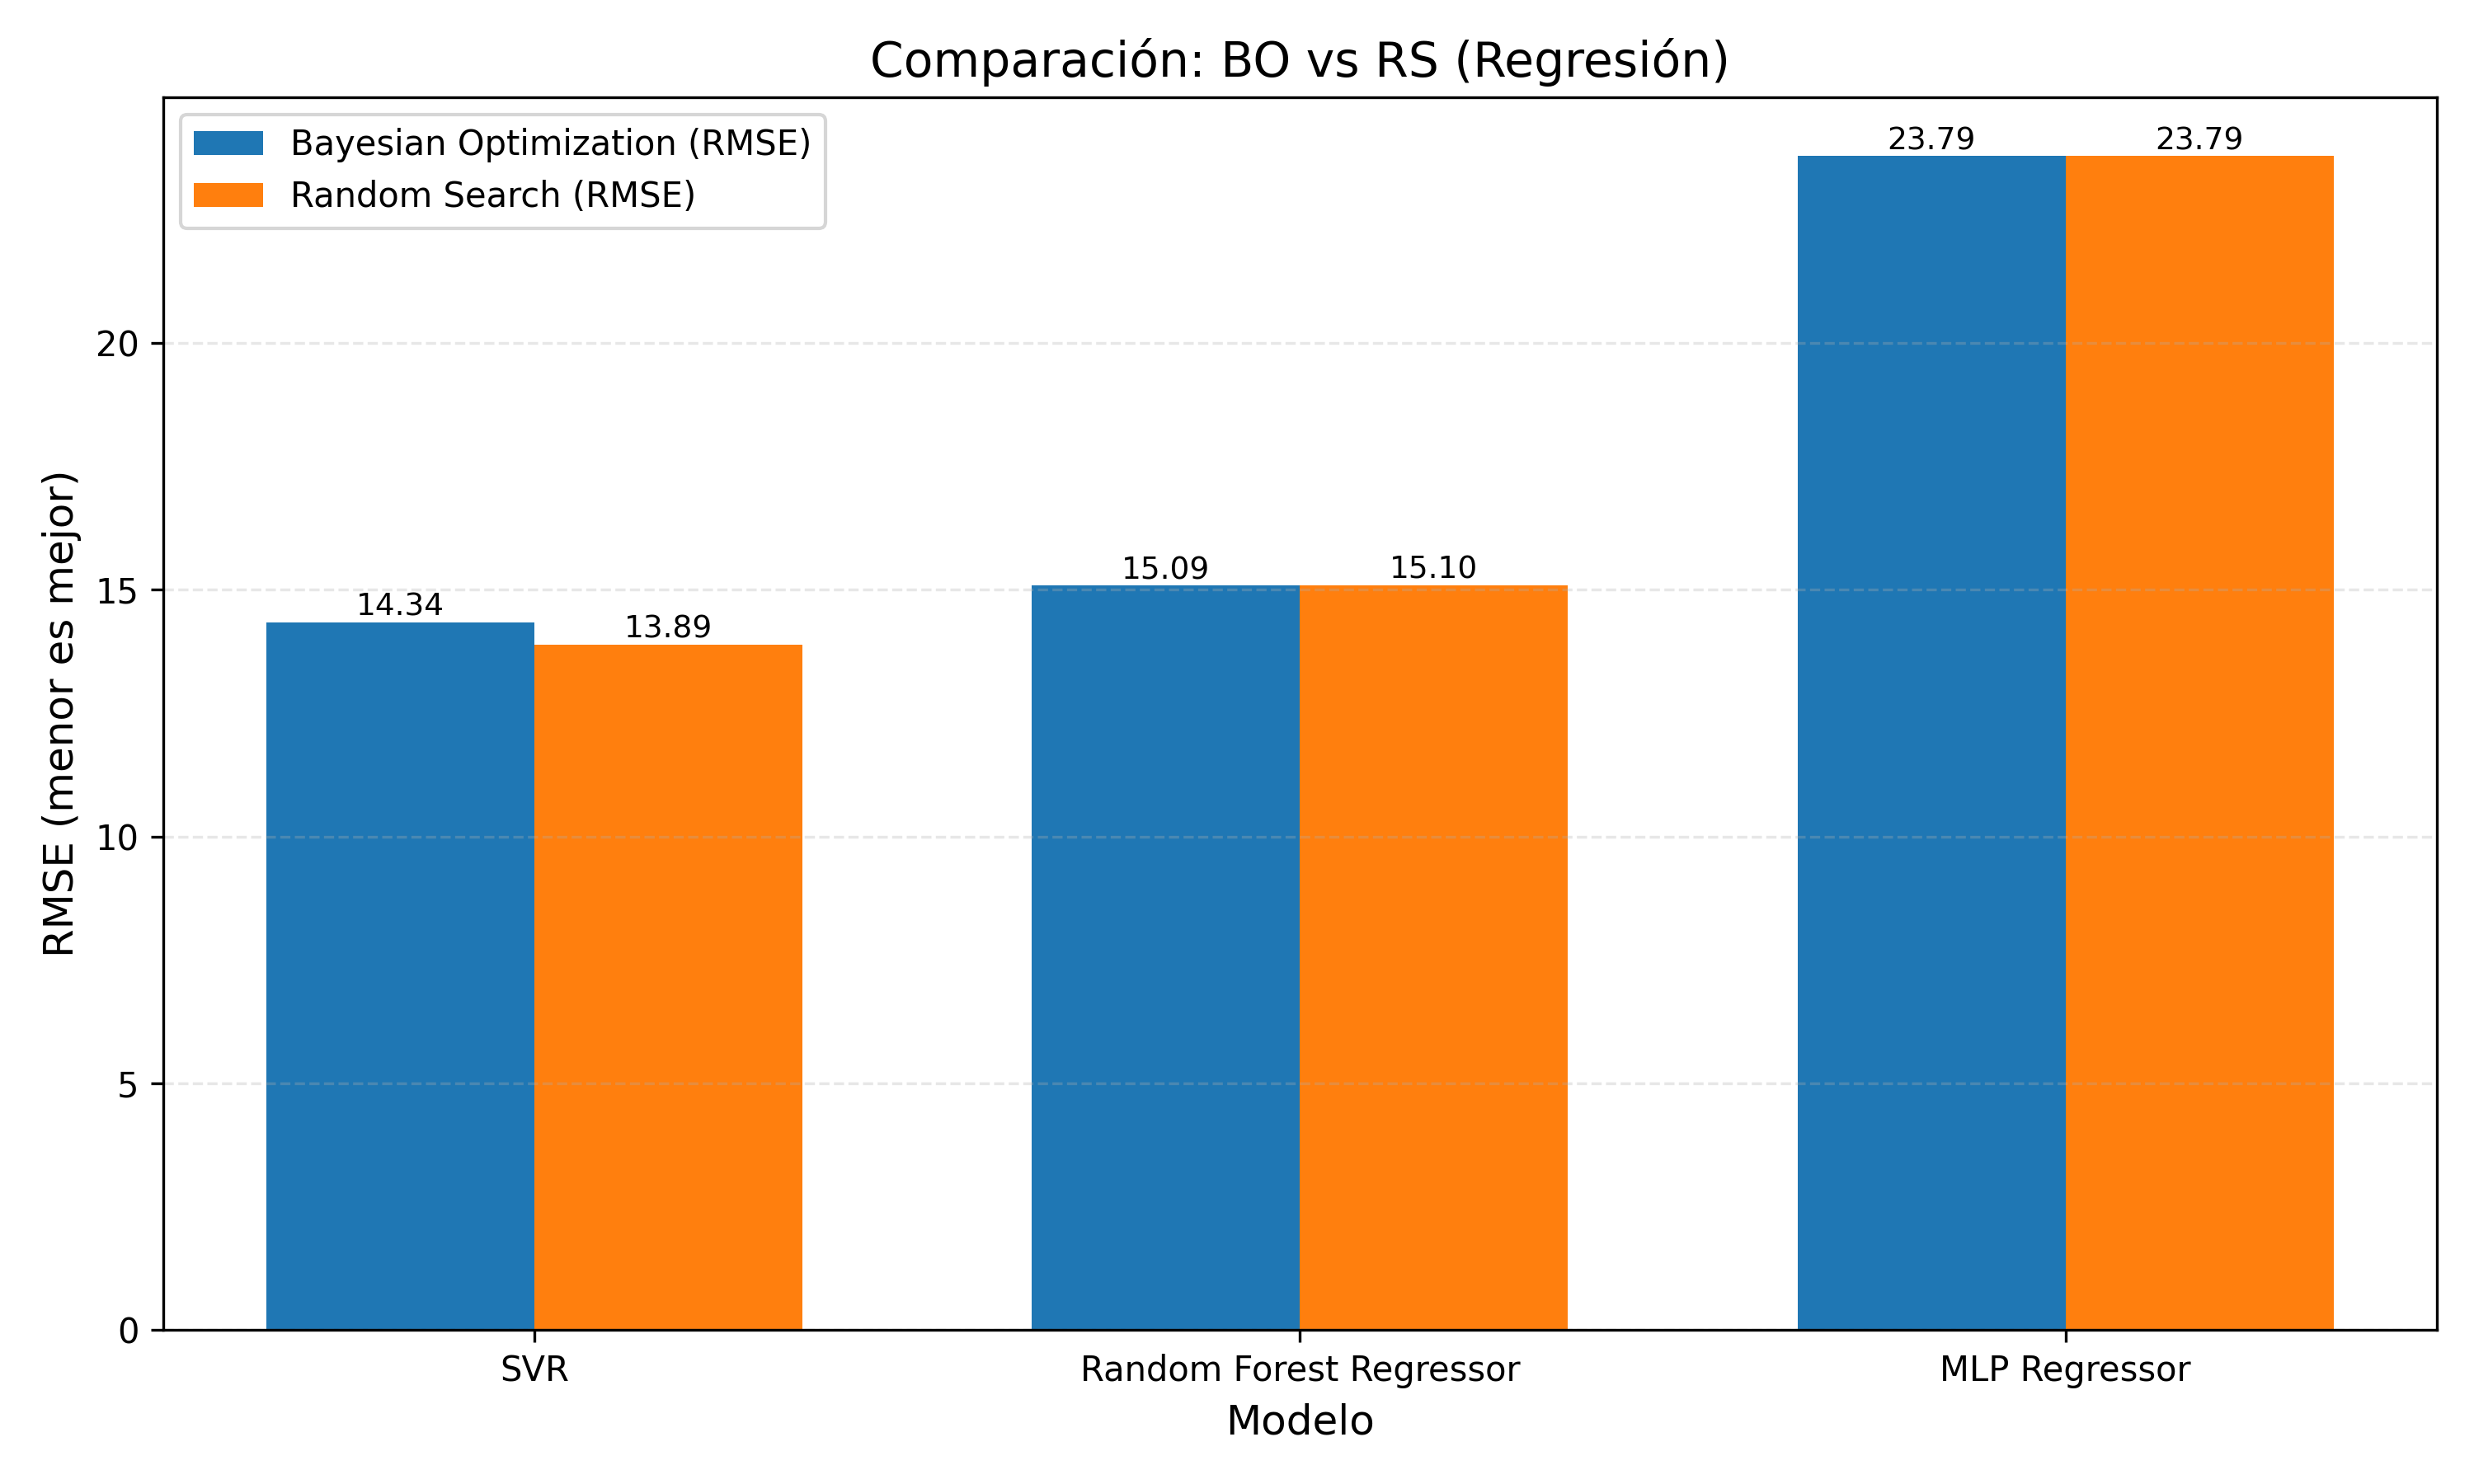

In [ ]:
from IPython.display import Image
Image('/content/results/comparison_plot.png')

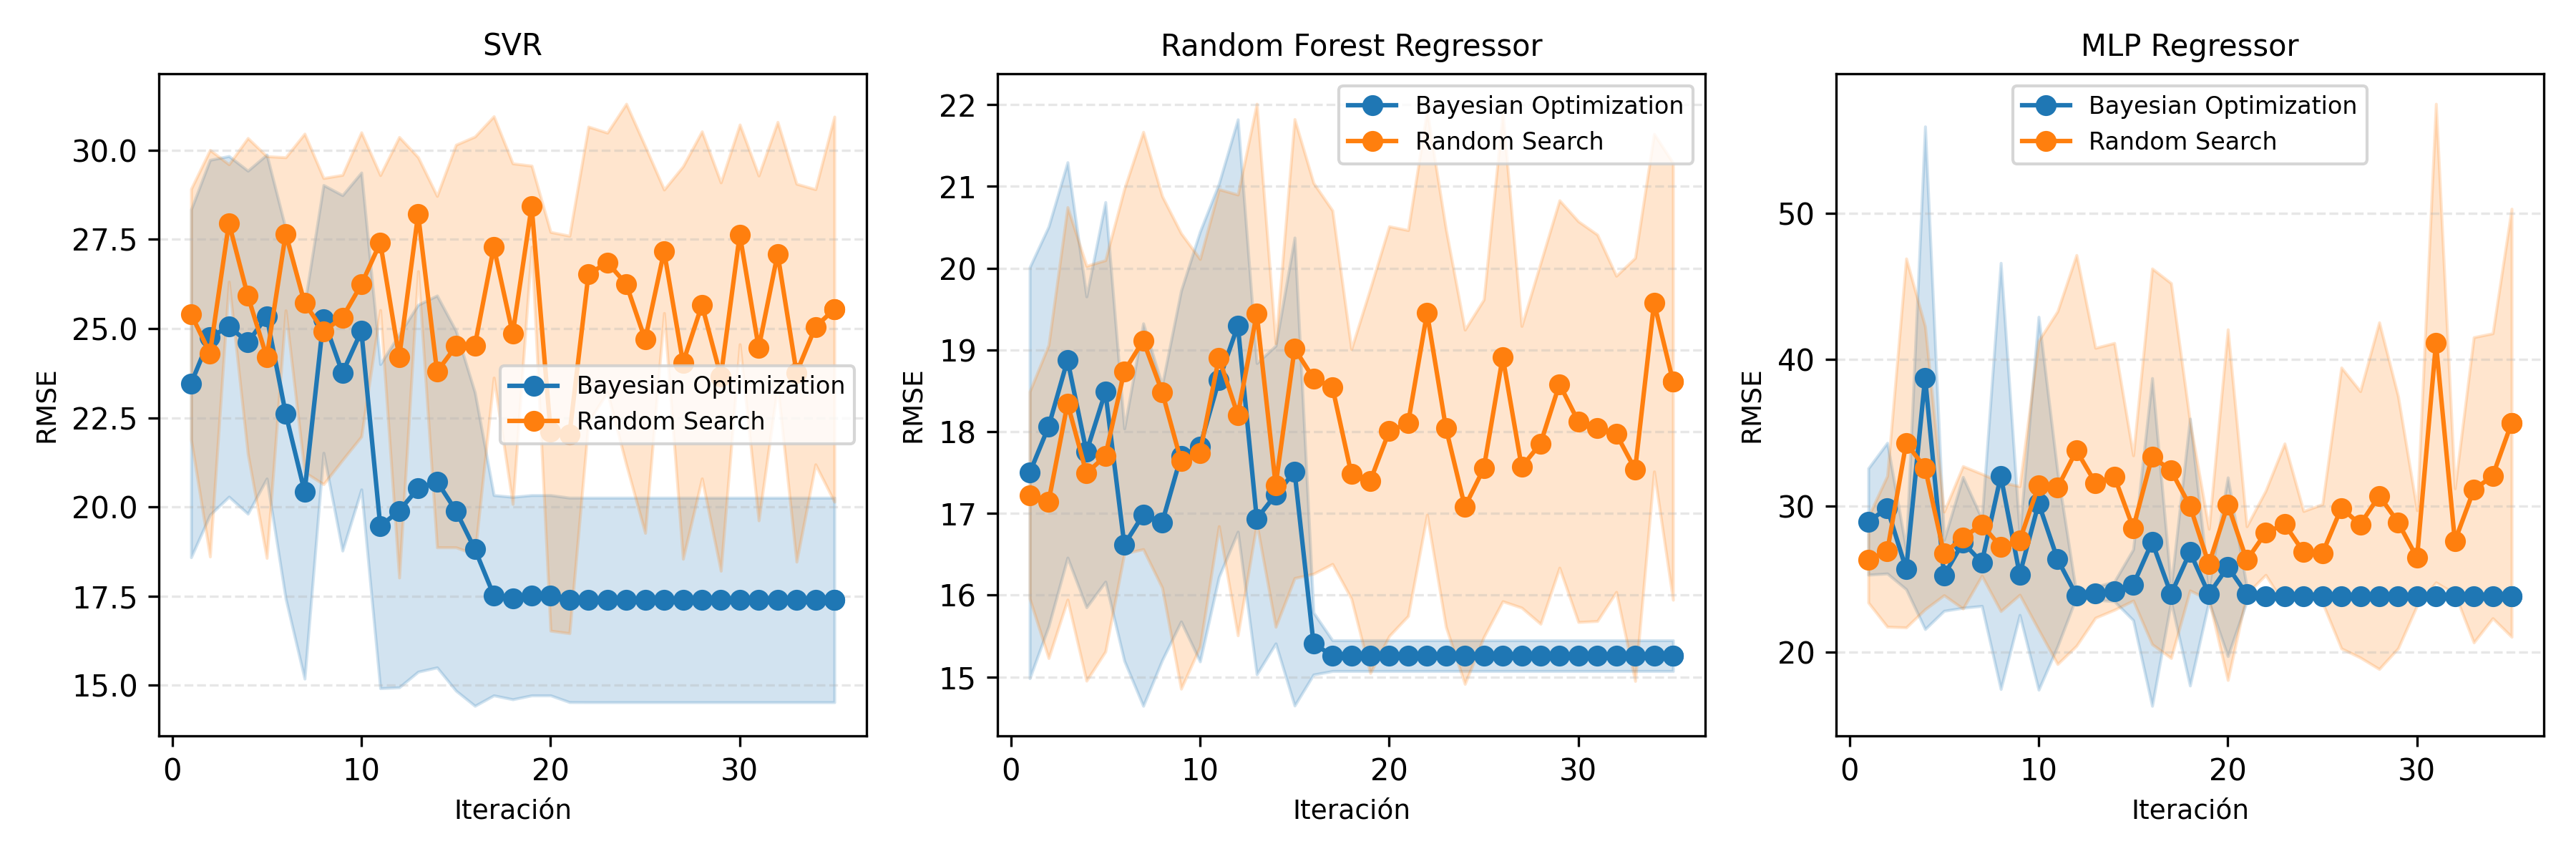

In [ ]:
Image('/content/results/error_history_iterations.png')